In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
from __future__ import print_function
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2
import sys
import os
import glob

import seaborn as sns
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import (KMeans, DBSCAN, AgglomerativeClustering, MiniBatchKMeans)
from sklearn.metrics import (cohen_kappa_score, confusion_matrix, classification_report, f1_score)

# For permutation tests
from sympy.utilities.iterables import multiset_permutations

from MulticoreTSNE import MulticoreTSNE as MTSNE

# config = tf.ConfigProto( device_count = {'GPU': 0} )

colors = [ 'firebrick', 'olivedrab', 'blueviolet', 'goldenrod', 'lightsalmon' ]
labels = ['G3', 'G4', 'G5', 'BN', 'ST']

In [2]:
# MODULE_URL = 'https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1'; MODULE_NAME='InceptionV3'
# MODULE_URL = 'https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/1'; MODULE_NAME='NasNet'
# MODULE_URL = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/1'; MODULE_NAME='Resnet50'
# MODULE_URL = 'https://tfhub.dev/google/imagenet/resnet_v2_101/feature_vector/1'; MODULE_NAME='Resnet101'
# MODULE_URL = 'https://tfhub.dev/google/imagenet/resnet_v2_152/feature_vector/1'; MODULE_NAME='Resnet152'
MODULE_URL = 'https://tfhub.dev/google/imagenet/mobilenet_v2_050_224/feature_vector/1'; MODULE_NAME='MobilenetV2'
# MODULE_URL = 'https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/1'; MODULE_NAME='InceptionResnet'

# config = tf.ConfigProto( device_count = {'GPU': 0} )
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

module = hub.Module(MODULE_URL)
height, width = hub.get_expected_image_size(module)
image_in = tf.placeholder('float', [1, height, width, 3])
z_op = module(image_in)
sess.run(tf.global_variables_initializer())
print(height, width)

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/beta:0 from checkpoint /tmp/tfhub_modules/26cdd9296b2b867c58539a0e2c1bebaaa5ce49dd/variables/variables with MobilenetV2/Conv/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/gamma:0 from checkpoint /tmp/tfhub_modules/26cdd9296b2b867c58539a0e2c1bebaaa5ce49dd/variables/variables with MobilenetV2/Conv/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/moving_mean:0 from checkpoint /tmp/tfhub_modules/26cdd9296b2b867c58539a0e2c1bebaaa5ce49dd/variables/variables with MobilenetV2/Conv/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/moving_variance:0 from checkpoint /tmp/tfhub_modules/26cdd9296b2b867c58539a0e2c1bebaaa5ce49dd/variables/variables with MobilenetV2/Conv/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/wei

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/weights:0 from checkpoint /tmp/tfhub_modules/26cdd9296b2b867c58539a0e2c1bebaaa5ce49dd/variables/variables with MobilenetV2/expanded_conv_1/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/beta:0 from checkpoint /tmp/tfhub_modules/26cdd9296b2b867c58539a0e2c1bebaaa5ce49dd/variables/variables with MobilenetV2/expanded_conv_10/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/gamma:0 from checkpoint /tmp/tfhub_modules/26cdd9296b2b867c58539a0e2c1bebaaa5ce49dd/variables/variables with MobilenetV2/expanded_conv_10/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/moving_mean:0 from checkpoint /tmp/tfhub_modules/26cdd9296b2b867c58539a0e2c1bebaaa5ce49dd/variables/variables with MobilenetV2/expanded_conv_10/depthwise/BatchNorm/

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_mean:0 from checkpoint /tmp/tfhub_modules/26cdd9296b2b867c58539a0e2c1bebaaa5ce49dd/variables/variables with MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_variance:0 from checkpoint /tmp/tfhub_modules/26cdd9296b2b867c58539a0e2c1bebaaa5ce49dd/variables/variables with MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/26cdd9296b2b867c58539a0e2c1bebaaa5ce49dd/variables/variables with MobilenetV2/expanded_conv_12/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/BatchNorm/beta:0 from checkpoint /tmp/tfhub_modules/26cdd9296b2b867c58539a0e2c1bebaaa5ce49dd/variables/variables with

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/26cdd9296b2b867c58539a0e2c1bebaaa5ce49dd/variables/variables with MobilenetV2/expanded_conv_14/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/BatchNorm/beta:0 from checkpoint /tmp/tfhub_modules/26cdd9296b2b867c58539a0e2c1bebaaa5ce49dd/variables/variables with MobilenetV2/expanded_conv_14/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/BatchNorm/gamma:0 from checkpoint /tmp/tfhub_modules/26cdd9296b2b867c58539a0e2c1bebaaa5ce49dd/variables/variables with MobilenetV2/expanded_conv_14/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/BatchNorm/moving_mean:0 from checkpoint /tmp/tfhub_modules/26cdd9296b2b867c58539a0e2c1bebaaa5ce49dd/variables/variables with MobilenetV2/expanded_conv_14/expand/Ba

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/gamma:0 from checkpoint /tmp/tfhub_modules/26cdd9296b2b867c58539a0e2c1bebaaa5ce49dd/variables/variables with MobilenetV2/expanded_conv_16/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_mean:0 from checkpoint /tmp/tfhub_modules/26cdd9296b2b867c58539a0e2c1bebaaa5ce49dd/variables/variables with MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_variance:0 from checkpoint /tmp/tfhub_modules/26cdd9296b2b867c58539a0e2c1bebaaa5ce49dd/variables/variables with MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/weights:0 from checkpoint /tmp/tfhub_modules/26cdd9296b2b867c58539a0e2c1bebaaa5ce49dd/variables/variables with MobilenetV2/expanded_conv_16

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/weights:0 from checkpoint /tmp/tfhub_modules/26cdd9296b2b867c58539a0e2c1bebaaa5ce49dd/variables/variables with MobilenetV2/expanded_conv_3/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/BatchNorm/beta:0 from checkpoint /tmp/tfhub_modules/26cdd9296b2b867c58539a0e2c1bebaaa5ce49dd/variables/variables with MobilenetV2/expanded_conv_3/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/BatchNorm/gamma:0 from checkpoint /tmp/tfhub_modules/26cdd9296b2b867c58539a0e2c1bebaaa5ce49dd/variables/variables with MobilenetV2/expanded_conv_3/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/BatchNorm/moving_mean:0 from checkpoint /tmp/tfhub_modules/26cdd9296b2b867c58539a0e2c1bebaaa5ce49dd/variables/variables with MobilenetV2/expanded_conv_3/project/BatchNorm/moving_mean
INFO:ten

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/moving_mean:0 from checkpoint /tmp/tfhub_modules/26cdd9296b2b867c58539a0e2c1bebaaa5ce49dd/variables/variables with MobilenetV2/expanded_conv_5/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/moving_variance:0 from checkpoint /tmp/tfhub_modules/26cdd9296b2b867c58539a0e2c1bebaaa5ce49dd/variables/variables with MobilenetV2/expanded_conv_5/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/weights:0 from checkpoint /tmp/tfhub_modules/26cdd9296b2b867c58539a0e2c1bebaaa5ce49dd/variables/variables with MobilenetV2/expanded_conv_5/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/beta:0 from checkpoint /tmp/tfhub_modules/26cdd9296b2b867c58539a0e2c1bebaaa5ce49dd/variables/variables with MobilenetV2/expanded_conv_6/depthwi

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/beta:0 from checkpoint /tmp/tfhub_modules/26cdd9296b2b867c58539a0e2c1bebaaa5ce49dd/variables/variables with MobilenetV2/expanded_conv_8/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/gamma:0 from checkpoint /tmp/tfhub_modules/26cdd9296b2b867c58539a0e2c1bebaaa5ce49dd/variables/variables with MobilenetV2/expanded_conv_8/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_mean:0 from checkpoint /tmp/tfhub_modules/26cdd9296b2b867c58539a0e2c1bebaaa5ce49dd/variables/variables with MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_variance:0 from checkpoint /tmp/tfhub_modules/26cdd9296b2b867c58539a0e2c1bebaaa5ce49dd/variables/variables with MobilenetV2/expand

In [3]:
allvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
print(len(allvars))
nparam = 0
for var in allvars:
    nparm = np.prod(var.get_shape())
    nparam += nparm
    print(var.name, var.get_shape(), nparm, nparam)
    
print(nparam)

260
module/MobilenetV2/Conv/weights:0 (3, 3, 3, 16) 432 432
module/MobilenetV2/Conv/BatchNorm/gamma:0 (16,) 16 448
module/MobilenetV2/Conv/BatchNorm/beta:0 (16,) 16 464
module/MobilenetV2/Conv/BatchNorm/moving_mean:0 (16,) 16 480
module/MobilenetV2/Conv/BatchNorm/moving_variance:0 (16,) 16 496
module/MobilenetV2/expanded_conv/depthwise/depthwise_weights:0 (3, 3, 16, 1) 144 640
module/MobilenetV2/expanded_conv/depthwise/BatchNorm/gamma:0 (16,) 16 656
module/MobilenetV2/expanded_conv/depthwise/BatchNorm/beta:0 (16,) 16 672
module/MobilenetV2/expanded_conv/depthwise/BatchNorm/moving_mean:0 (16,) 16 688
module/MobilenetV2/expanded_conv/depthwise/BatchNorm/moving_variance:0 (16,) 16 704
module/MobilenetV2/expanded_conv/project/weights:0 (1, 1, 16, 8) 128 832
module/MobilenetV2/expanded_conv/project/BatchNorm/gamma:0 (8,) 8 840
module/MobilenetV2/expanded_conv/project/BatchNorm/beta:0 (8,) 8 848
module/MobilenetV2/expanded_conv/project/BatchNorm/moving_mean:0 (8,) 8 856
module/MobilenetV2/ex

## Populate a matrix of feature vectors

In [4]:
jpg_list = sorted(glob.glob('../data/jpg/*.jpg'))
mask_list = sorted(glob.glob('../data/mask/*.png'))

img_classes = []
orig_imgs = []

z_vectors = []
idx = 0

resize = 1.
# resize = 0.5
# resize = 0.25
crop_size = int(height * (1/resize))

samples = 10
x0_vect = np.linspace(0, 1200-crop_size, samples, dtype=np.int)
y0_vect = np.linspace(0, 1200-crop_size, samples, dtype=np.int)
coords = zip(x0_vect, y0_vect)

for img_idx, (jpg, mask) in enumerate(zip(jpg_list, mask_list)):
    y = cv2.imread(mask, -1)
    x = cv2.imread(jpg, -1)[:,:,::-1]
               
    for k in range(samples):
        x0 = np.random.randint(0, 1200-crop_size)
        y0 = np.random.randint(0, 1200-crop_size)
        
        ## Grab the majority label
        y_ = y[x0:x0+crop_size, y0:y0+crop_size]
        totals = np.zeros(5)
        for k in range(5):
            totals[k] = (y_==k).sum()

        # Check for majority
        maj = np.argmax(totals)   
        if totals[maj] > 0.5 * (crop_size**2):
            # check for stroma -- two ways to skip stroma
            if maj==4 and totals[maj] < 0.95 * (crop_size*2):
                continue
#             elif maj==4 and np.random.randn(1) < 0.5:
            elif maj==4 and np.random.choice([0,1], p=[0.1, 0.9]):
                continue
        else:
            continue

        img_classes.append(maj)
        orig_imgs.append(img_idx)
        idx += 1
        if idx % 250 == 0:
            print('[{} / {}]'.format(img_idx, len(jpg_list)))
        x_ = x[x0:x0+crop_size, y0:y0+crop_size, :]
        x_ = cv2.resize(x_, dsize=(0,0), fx=resize, fy=resize)
        x_ = x_ * (1/255.)
        x_ = np.expand_dims(x_, 0)
        
        z = sess.run(z_op, feed_dict={image_in: x_})

        z_vectors.append(z)
    
    
z_vectors = np.concatenate(z_vectors, axis=0)

img_classes = np.asarray(img_classes)
orig_imgs = np.asarray(orig_imgs)
print('z vectors', z_vectors.shape)
print('img classes', img_classes.shape)
print('got classes:', np.unique(img_classes))

manifold = MTSNE(n_jobs=8, n_components=2, verbose=1)
z_manifold = manifold.fit_transform(z_vectors)
print('z manifold', z_manifold.shape)

[46 / 625]
[198 / 625]
[224 / 625]
[251 / 625]
[282 / 625]
[315 / 625]
[354 / 625]
[433 / 625]
[469 / 625]
[520 / 625]
[569 / 625]
[617 / 625]
z vectors (3056, 1280)
img classes (3056,)
got classes: [0 1 2 3 4]
z manifold (3056, 2)


## Cluter the z vectors

In [5]:
# Compare label assignments with the annotation
# clustered = clusterer.labels_

max_kappa = 0.0
max_f1 = 0.0
best_remapped = None

for vers in range(10):
    clusterer = MiniBatchKMeans(n_clusters=5, verbose=0, n_init=100).fit(z_vectors)
    clustered = clusterer.labels_
    
    for perm in multiset_permutations(range(5)):
        # Pick a mapping clustered --> labels
        mapping = {x: k for x, k in zip(range(5), perm)}

        clustered_remapped = np.asarray([mapping[y] for y in clustered])

        kappa = cohen_kappa_score(img_classes, clustered_remapped)
        f1 = f1_score(img_classes, clustered_remapped, average='weighted')
# 
#         print(vers, f1, max_f1)
#         if kappa > max_kappa:
        if f1 > max_f1:
            best_remapped = clustered_remapped
            max_kappa = kappa
            max_f1 = f1
            print(vers, kappa, f1)
            print(mapping)
            print(classification_report(img_classes, clustered_remapped), end='\n\n')

0 0.07065154439956889 0.29015999774648094
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4}
             precision    recall  f1-score   support

          0       0.17      0.18      0.17       470
          1       0.57      0.32      0.41      1336
          2       0.35      0.49      0.41       541
          3       0.02      0.01      0.02       349
          4       0.06      0.13      0.08       360

avg / total       0.35      0.27      0.29      3056


0 0.16593170117235034 0.3742844893344548
{0: 0, 1: 1, 2: 2, 3: 4, 4: 3}
             precision    recall  f1-score   support

          0       0.17      0.18      0.17       470
          1       0.57      0.32      0.41      1336
          2       0.35      0.49      0.41       541
          3       0.05      0.12      0.07       349
          4       0.84      0.66      0.74       360

avg / total       0.45      0.34      0.37      3056


0 0.2841267495289236 0.4484212685872813
{0: 3, 1: 0, 2: 1, 3: 4, 4: 2}
             precision    recall  

Text(0.5,0.98,'MobileNet \nF1=0.489')

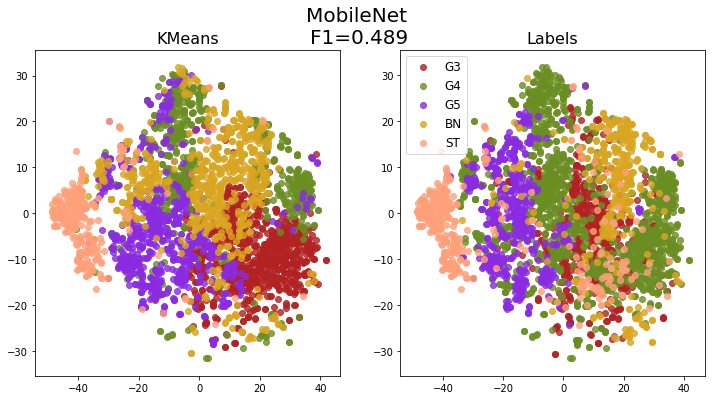

In [10]:
fig, axs = plt.subplots(1,2, figsize=(12, 6))

for k in range(5):
    idxs = np.where(best_remapped==k)
    sns.regplot(z_manifold[idxs,0], z_manifold[idxs,1], fit_reg=False, color=colors[k], ax=axs[0])
    
    idxs = np.where(img_classes==k)
    sns.regplot(z_manifold[idxs,0], z_manifold[idxs,1], fit_reg=False, color=colors[k], label=labels[k], ax=axs[1])

axs[0].set_title('KMeans', fontsize=16)
axs[1].set_title('Labels', fontsize=16)
plt.legend(fontsize=12)
# plt.suptitle(u'{}\n$\kappa={:3.3f}$'.format(MODULE_NAME, max_kappa), fontsize=20)
plt.suptitle('MobileNet \nF1={:3.3f}'.format(max_f1), fontsize=20)
# plt.savefig('/home/nathan/Dropbox/_papers/gleason_grade/{}_kmeans.pdf'.format(MODULE_NAME), bbox_inches='tight')

In [11]:
fig.savefig('/home/nathan/Dropbox/_papers/gleason_grade/mobilenet_kmeans.pdf', bbox_inches='tight')